## Important Packege installation

In [2]:
"""%pip install tf-keras"""

'%pip install tf-keras'

# Required Dependencies

In [3]:
import pandas as pd
import json
import os
import numpy as np
import io

# Plotting 
import matplotlib.pyplot as plt

# ML
import keras
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Bidirectional, LSTM
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

c:\Users\PanSt\Desktop\4ML\Sarcasm-Detection-using-NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data collection and preprocessing

In [4]:
base_dir = "C:/Users/PanSt/Desktop/4ML/Sarcasm-Detection-using-NLP/sarcasm dataset"
train_data = os.path.join(base_dir, 'Sarcasm_Headlines_Dataset.json').replace('\\', '/')
test_data = os.path.join(base_dir, 'Sarcasm_Headlines_Dataset_v2.json').replace('\\', '/')

In [5]:
data = []
with open(train_data, 'r') as file:
    for line in file:
        data.append(json.loads(line))

data = pd.DataFrame(data)

### Check train data first

In [6]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


<Axes: xlabel='is_sarcastic'>

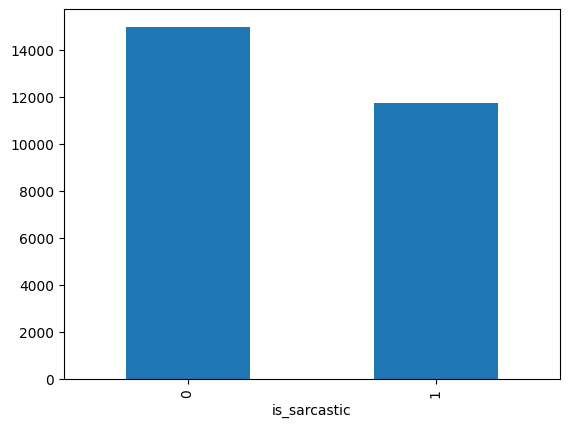

In [7]:
data['is_sarcastic'].value_counts().plot.bar()

In [8]:
data.duplicated().value_counts()

False    26708
True         1
Name: count, dtype: int64

In [9]:
train = data.drop_duplicates()
train.duplicated().value_counts()

False    26708
Name: count, dtype: int64

### Train Test split

In [10]:
train_ratio = 0.8
train_size = int(len(data)*train_ratio)
train_size

21367

In [11]:
X_train = data['headline'].values[0:train_size]
y_train = data['is_sarcastic'].values[0:train_size]

X_test = data['headline'].values[train_size:]
y_test = data['is_sarcastic'].values[train_size:]

# 2. Preprocessing the train and test sets

In [12]:
vocab_size = 10000 # Vocabulary size of the tokenizer
max_length = 32 # Maximum length of the padded sequences
embedding_dim = 16 # Output dimensions of the Embedding layer

In [13]:
truncating = 'post'
padding = 'post'
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate, pad and truncate train sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding, truncating=truncating)

# Generate, pad and truncate test sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding, truncating=truncating)

# 3. Modelling

In [14]:
tensorflow.keras.backend.clear_session()

## Callbacks

In [15]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99.0% accuracy -> Terminating Training")
      self.model.stop_training = True

callbacks = myCallback()

## a. Simple NN

In [16]:
# Build the model
model1 = tensorflow.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Print the model summary
model1.summary()

c:\Users\PanSt\Desktop\4ML\Sarcasm-Detection-using-NLP\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,577 (627.25 KB)

 Trainable params: 160,577 (627.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model1.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history1 = model1.fit(X_train_pad, y_train, epochs=30, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
668/668 - 5s - 8ms/step - accuracy: 0.5593 - loss: 0.6867 - val_accuracy: 0.5680 - val_loss: 0.6812
Epoch 2/30
668/668 - 5s - 7ms/step - accuracy: 0.5593 - loss: 0.6794 - val_accuracy: 0.5680 - val_loss: 0.6728
Epoch 3/30
668/668 - 2s - 3ms/step - accuracy: 0.5607 - loss: 0.6658 - val_accuracy: 0.5777 - val_loss: 0.6539
Epoch 4/30
668/668 - 3s - 4ms/step - accuracy: 0.6308 - loss: 0.6353 - val_accuracy: 0.6842 - val_loss: 0.6158
Epoch 5/30
668/668 - 2s - 3ms/step - accuracy: 0.7486 - loss: 0.5879 - val_accuracy: 0.7791 - val_loss: 0.5677
Epoch 6/30
668/668 - 2s - 3ms/step - accuracy: 0.8076 - loss: 0.5351 - val_accuracy: 0.8053 - val_loss: 0.5207
Epoch 7/30
668/668 - 2s - 3ms/step - accuracy: 0.8298 - loss: 0.4873 - val_accuracy: 0.8089 - val_loss: 0.4829
Epoch 8/30
668/668 - 2s - 3ms/step - accuracy: 0.8384 - loss: 0.4491 - val_accuracy: 0.8250 - val_loss: 0.4541
Epoch 9/30
668/668 - 3s - 4ms/step - accuracy: 0.8476 - loss: 0.4181 - val_accuracy: 0.8302 - val_loss: 0.4319
E

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

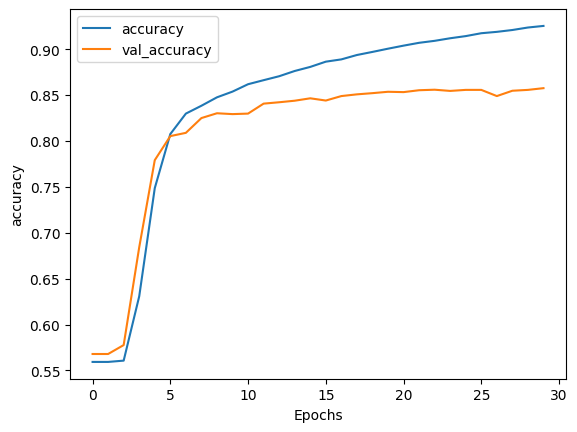

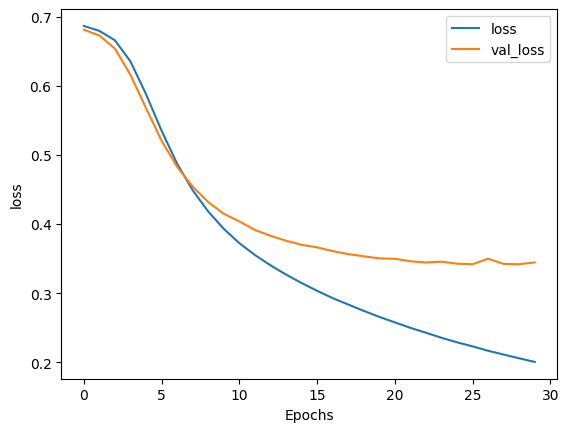

In [19]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

## b. LSTM

In [20]:
model2 = tensorflow.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,801 (956.25 KB)

 Trainable params: 244,801 (956.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model2.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00002), metrics=['accuracy'])
history2 = model2.fit(X_train_pad, y_train, epochs=30, validation_data=(X_test_pad, y_test), verbose=1, callbacks=[callbacks])

Epoch 1/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5446 - loss: 0.6906 - val_accuracy: 0.5680 - val_loss: 0.6822
Epoch 2/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.5579 - loss: 0.6825 - val_accuracy: 0.5792 - val_loss: 0.6446
Epoch 3/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.7236 - loss: 0.5349 - val_accuracy: 0.7898 - val_loss: 0.4529
Epoch 4/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8181 - loss: 0.4127 - val_accuracy: 0.7922 - val_loss: 0.4368
Epoch 5/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8428 - loss: 0.3673 - val_accuracy: 0.8077 - val_loss: 0.4106
Epoch 6/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8599 - loss: 0.3400 - val_accuracy: 0.8162 - val_loss: 0.4019
Epoch 7/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.8746 - loss: 0.3111 - val_accuracy: 0.8218 - val_loss: 0.3936
Epoch 8/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.8854 - loss: 0.2884 - 

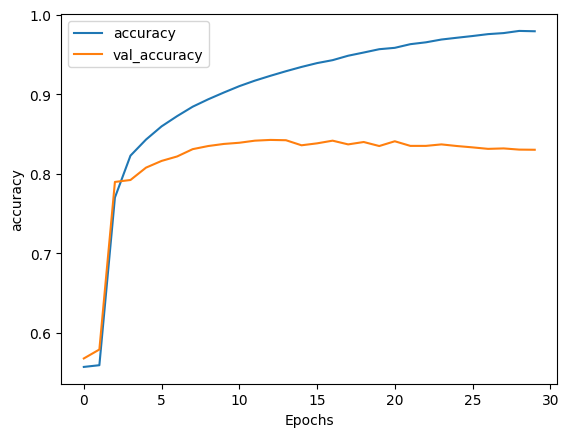

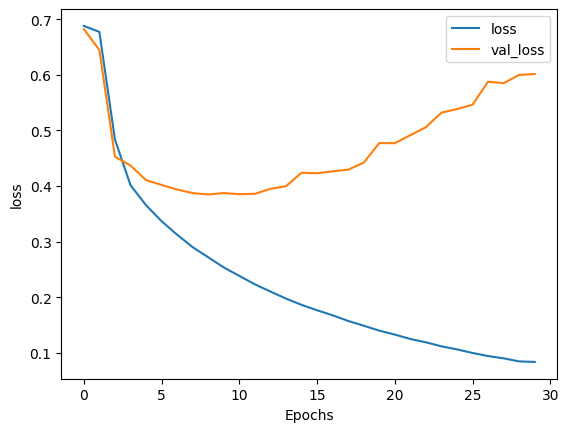

In [22]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# 4. Visualize Word Embeddings

In [23]:
reverse_word_index = tokenizer.index_word
embedding_layer = model2.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(10000, 16)


In [24]:
# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [25]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

Visit https://projector.tensorflow.org/ to visualize the results